In this project we will analyze several condition that make the machine tend to be failured and build the model that can identify whether or not the machine were failured. Later on this can be used to do maintenance prediction for the machine that we predicted to be failured

Objective:

1. identify what are the most frequent type of failure occurs and why it happens
2. determine the correlation between type of machine with the occurance of the failure case
3. determine which condition (features) that tend to make the machine failure
4. compare several model (SVM, Logistic Regression, KNN, and Decision Tree) to see how accurate it is in predicting failured. 

Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, this dataset provide a synthetic dataset that reflects real machine failure encountered in industry gathered from UCI Machine Learning Repository 

Note:
1. All features are unscaled and there were some miss imputed on the target's feature, there are some machine that were failure imputed as not failure, so we need to crosscheck it to the failure's type features.
2. There are no "Null" values, so we don't have to work on ways to replace values.
3. Most of the case were no failure (96.5 %) of the time, while failure occurs (3.5 %) of the time in the dataframe


# Import the moduls

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [42]:
df = pd.read_csv('predictive_maintenance.csv', header= 0)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


Identify the columns type and the shape of the data

In [4]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

In [15]:
df.shape

(10000, 8)

There are some unneeded column like UDI and Product ID that were randomly assigned which we will not use it
for our analysis

In [43]:
df.drop(['UDI', 'Product ID'], axis= 1, inplace= True)

Rename and changing the column's name to the 'normal' format to make it easier to write

In [44]:
df = df.rename(columns={'Type': 'type', 'Air temperature [K]': 'air_temperature',
                        'Process temperature [K]': 'process_temperature',
                        'Rotational speed [rpm]': 'rotational_speed',
                        'Torque [Nm]': 'torque', 'Tool wear [min]': 'tool_wear_min',
                        'Target': 'target', 'Failure Type': 'failure_type'})

In [45]:
df['failure_type'] = df['failure_type'].str.replace(' ', '_') 
df['failure_type'] = df['failure_type'].str.lower()

Identify missing and duplicated values in the data

In [6]:
df.isna().sum()

type                   0
air_temperature        0
process_temperature    0
rotational_speed       0
torque                 0
tool_wear_min          0
target                 0
failure_type           0
dtype: int64

In [13]:
df.duplicated().sum()

0

Identify the count of our target values

In [13]:
df['target'].value_counts()

0    9661
1     339
Name: target, dtype: int64

The target's value '0' represent 'No Failure' and value '1' represent 'Failure'

In [14]:
df['failure_type'].value_counts()

no_failure                  9652
heat_dissipation_failure     112
power_failure                 95
overstrain_failure            78
tool_wear_failure             45
random_failures               18
Name: failure_type, dtype: int64

There are some miss observation in 'no failure' values on target's column and failure type's column, we can see that the count of the values 'no failure' in the target's column is not equal to its count in failure type's column , so we need to find the values that miss imputed to the data 

In [46]:
df_random_failure = df.loc[(df['target'] == 0) & (df['failure_type'] != 'no_failure')]
df_random_failure

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear_min,target,failure_type
1221,M,297.0,308.3,1399,46.4,132,0,random_failures
1302,L,298.6,309.8,1505,45.7,144,0,random_failures
1748,H,298.4,307.7,1626,31.1,166,0,random_failures
2072,L,299.6,309.5,1570,35.5,189,0,random_failures
2559,L,299.3,309.0,1447,50.4,140,0,random_failures
3065,M,300.1,309.2,1687,27.7,95,0,random_failures
3452,H,301.6,310.5,1602,32.3,2,0,random_failures
5471,L,302.7,312.3,1346,61.2,170,0,random_failures
5489,L,302.6,312.1,1499,35.0,215,0,random_failures
5495,H,302.9,312.5,1357,55.0,12,0,random_failures


In this case there are 18 rows in failure's type column specifically 'random failure'
that have a value '0' in target's columns,  we know that the values '0' indicates no failure,
so we need to replace the value to '1' that represent failures

In [47]:
df.loc[df['failure_type'] == 'random_failures', 'target'] = 1
df['target'].value_counts()

0    9643
1     357
Name: target, dtype: int64

In [8]:
df['failure_type'].value_counts()

no_failure                  9652
heat_dissipation_failure     112
power_failure                 95
overstrain_failure            78
tool_wear_failure             45
random_failures               18
Name: failure_type, dtype: int64

Yet still have some miss observation where the '0' values in target's column is still not equal
to total values of 'no failure' in failure type's column.

In [48]:
df_failure_type_error = df[(df['target'] != 0) & (df['failure_type'] == 'no_failure')]
df_failure_type_error

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear_min,target,failure_type
1437,H,298.8,309.9,1439,45.2,40,1,no_failure
2749,M,299.7,309.2,1685,28.9,179,1,no_failure
4044,M,301.9,310.9,1419,47.7,20,1,no_failure
4684,M,303.6,311.8,1421,44.8,101,1,no_failure
5536,M,302.3,311.8,1363,54.0,119,1,no_failure
5941,L,300.6,310.7,1438,48.5,78,1,no_failure
6478,L,300.5,309.8,1663,29.1,145,1,no_failure
8506,L,298.4,309.6,1710,27.3,163,1,no_failure
9015,L,297.2,308.1,1431,49.7,210,1,no_failure


In this case there are 9 rows in failure's type column specifically 'no failure'
that have a value '1' in target's columns,  we also know that '1' indicates failure,
so we need to replace the target's value to '0' that represent no failures

In [49]:
df_failure_type_error.loc[:, 'target'] = 0
df.update(df_failure_type_error)
df['target'] = df['target'].astype('int')
df.head()

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear_min,target,failure_type
0,M,298.1,308.6,1551.0,42.8,0.0,0,no_failure
1,L,298.2,308.7,1408.0,46.3,3.0,0,no_failure
2,L,298.1,308.5,1498.0,49.4,5.0,0,no_failure
3,L,298.2,308.6,1433.0,39.5,7.0,0,no_failure
4,L,298.2,308.7,1408.0,40.0,9.0,0,no_failure


In [18]:
df['target'].value_counts()

0    9652
1     348
Name: target, dtype: int64

In [12]:
df['failure_type'].value_counts() # validation

no_failure                  9652
heat_dissipation_failure     112
power_failure                 95
overstrain_failure            78
tool_wear_failure             45
random_failures               18
Name: failure_type, dtype: int64

Now our data is ready to be explored

# Ekploratory Data Analysis

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temperature,10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
process_temperature,10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
rotational_speed,10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
torque,10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
tool_wear_min,10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0
target,10000.0,0.03480,0.183282,0.0,0.0,0.0,0.0,1.0


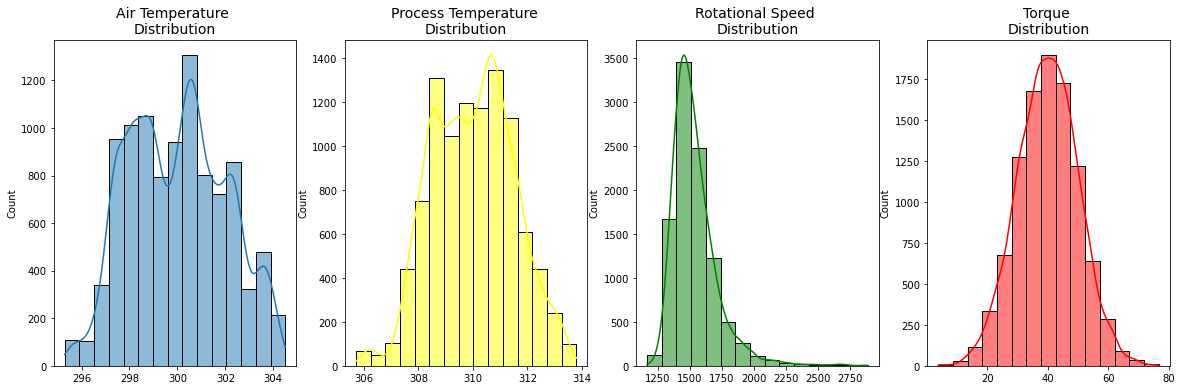

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(20,6))

# fig.suptitle('Distribution Of Each Features', fontsize=20)

sns.histplot(df, x='air_temperature', bins= 15, kde=True, ax=ax[0])
ax[0].set_title('Air Temperature \nDistribution', fontsize=14)
ax[0].set_xlabel('')

sns.histplot(df, x='process_temperature', bins= 15, kde=True, ax=ax[1], color='yellow')
ax[1].set_title('Process Temperature \nDistribution', fontsize=14)
ax[1].set_xlabel('')

sns.histplot(df, x='rotational_speed', bins= 15, kde=True, ax=ax[2], color='green')
ax[2].set_title('Rotational Speed \nDistribution', fontsize=14)
ax[2].set_xlabel('')

sns.histplot(df, x='torque', bins= 15, kde=True, ax=ax[3], color='red')
ax[3].set_title('Torque \nDistribution', fontsize=14)
ax[3].set_xlabel('')

plt.show()

From the histplot above we can see that each features were normally distributed except the rotational speed features that have positively skewed. On the normally distributed data we can say that the majority of the data were spread along the mean or the median of the data and in the positively skewed data (in this case the rotational speed columns) the majority of the data lie under the value of the mean

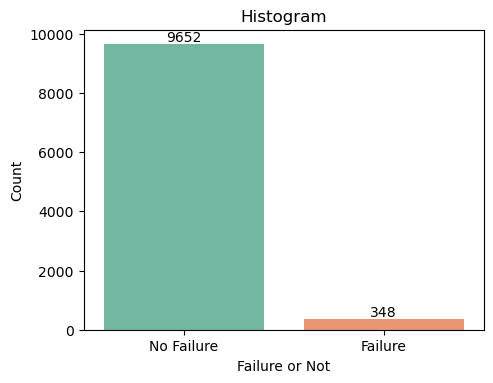

In [55]:
fig = plt.figure(figsize=(8,6), dpi= 100)
#ax = sns.set_theme(style="whitegrid")
ax = fig.add_axes([0.1, 0.1, 0.5, 0.5])
ax = sns.countplot(data=df, x='target', palette="Set2")

for c in ax.containers:
    ax.bar_label(c)

ax.set_title('Histogram')
ax.set_xlabel('Failure or Not')
ax.set_ylabel('Count')
ax.set_xticklabels(['No Failure', 'Failure'])
plt.show()

The data showed about 96.5 % of the target variabel were no failures and only
about 3.5 % of the target variabel were failures. It means that the data were 
highly imbalanced and we need to to some treatment to make each target's feature were equal

In [56]:
df_failure= df[df['failure_type'] != "no_failure"]
failure_sorted = df_failure.groupby('failure_type')['target'].count().sort_values(ascending=False)
failure_sorted

failure_type
heat_dissipation_failure    112
power_failure                95
overstrain_failure           78
tool_wear_failure            45
random_failures              18
Name: target, dtype: int64

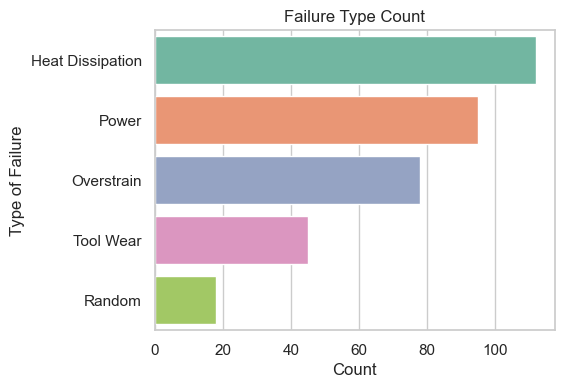

In [57]:
fig = plt.figure(figsize=(8,6), dpi= 100)
ax = sns.set_theme(style="whitegrid")
ax = fig.add_axes([0.1, 0.1, 0.5, 0.5])
ax = sns.countplot(data= df.query('failure_type != "no_failure"'), y='failure_type',
                   palette="Set2", order=['heat_dissipation_failure', 'power_failure',
                                         'overstrain_failure', 'tool_wear_failure',
                                         'random_failures'])

ax.set_title('Failure Type Count')
ax.set_xlabel('Count')
ax.set_ylabel('Type of Failure')
ax.set_yticklabels(['Heat Dissipation','Power','Overstrain','Tool Wear','Random'], rotation= 0)
plt.show()

Insight:

The most frequent failure's that occurs in the machine product sequentially are Heat Dissipation Failure, Power Failure
Overstrain Failure, Total Wear Failure and Random failure

<Figure size 900x700 with 0 Axes>

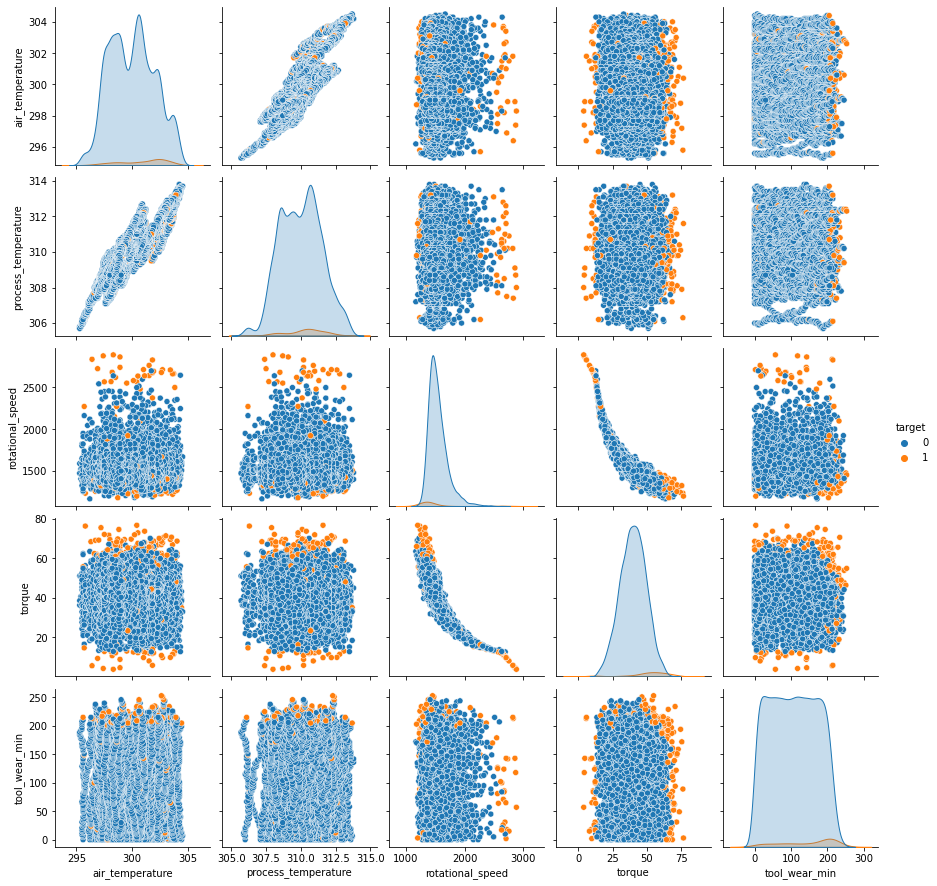

In [17]:
fig = plt.figure(figsize=(9,7), dpi= 100)
sns.pairplot(df, hue='target')
plt.show()

[Text(0, 0, 'Power'),
 Text(1, 0, 'Toolwear'),
 Text(2, 0, 'Overstrain'),
 Text(3, 0, 'Random'),
 Text(4, 0, 'Heat Dissipation')]

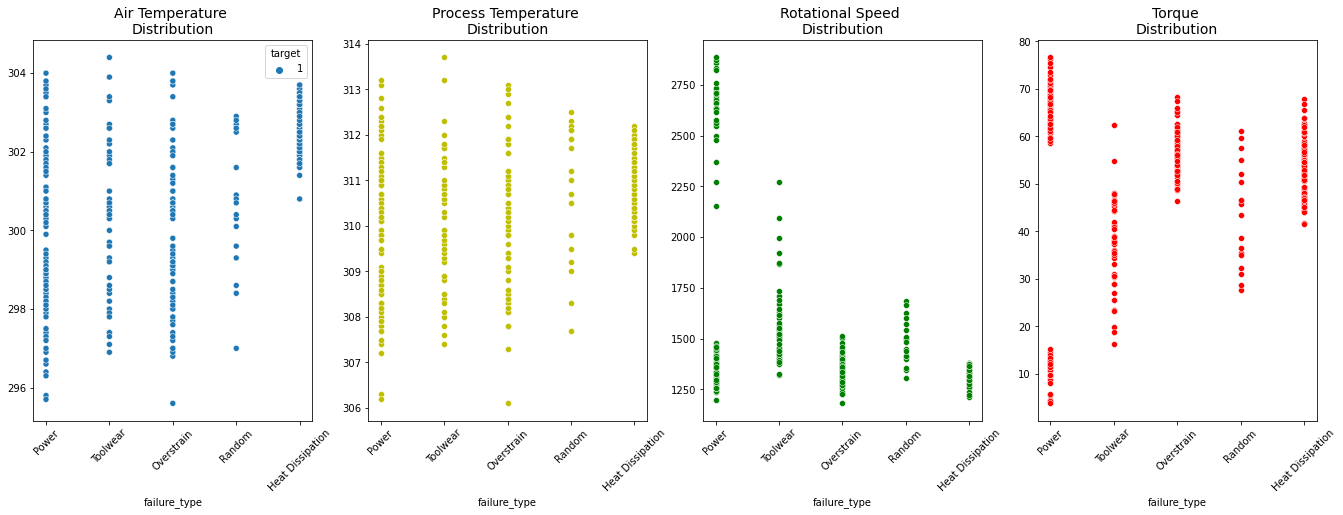

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(23,7))

xticklabels = ['Power', 'Toolwear', 'Overstrain', 'Random', 'Heat Dissipation']

sns.scatterplot(data=df.query('failure_type != "no_failure"'), x='failure_type', y='air_temperature', hue='target', color='blue', ax=ax[0])
ax[0].set_title('Air Temperature \nDistribution', fontsize=14)
ax[0].set_ylabel('')
ax[0].set_xticklabels(xticklabels, rotation = 45)

sns.scatterplot(data=df.query('failure_type != "no_failure"'), x='failure_type', y='process_temperature', color='y', ax=ax[1])
ax[1].set_title('Process Temperature \nDistribution', fontsize=14)
ax[1].set_ylabel('')
ax[1].set_xticklabels(xticklabels, rotation = 45)

sns.scatterplot(data=df.query('failure_type != "no_failure"'), x='failure_type', y='rotational_speed', color='green', ax=ax[2])
ax[2].set_title('Rotational Speed \nDistribution', fontsize=14)
ax[2].set_ylabel('')
ax[2].set_xticklabels(xticklabels, rotation = 45)

sns.scatterplot(data=df.query('failure_type != "no_failure"'), x='failure_type', y='torque', color='r', ax=ax[3])
ax[3].set_title('Torque \nDistribution', fontsize=14)
ax[3].set_ylabel('')
ax[3].set_xticklabels(xticklabels, rotation = 45)



Insight:

1. The most frequent failure's i.e heat dissipation failure occurs in the high temperature, in this case, it occurs when the air temperature between 301K - 304K and process temperature between 309K - 314K, also same with the torque features, the heat dissipation occurs when the torque value were high or between 40 - 70 Nm. But it is reversed to rotational speed feature's where the heat dissipation occurs on the low value of rotational speed between 1250 - 1350 rpm

2. The most unfrequent failure's i.e random failure occurs with evenly distributed in the middle value of all feature's except for the rotational speed , it mostly occurs in low value, in this case rotational speed betweed 1250K - 1750K  

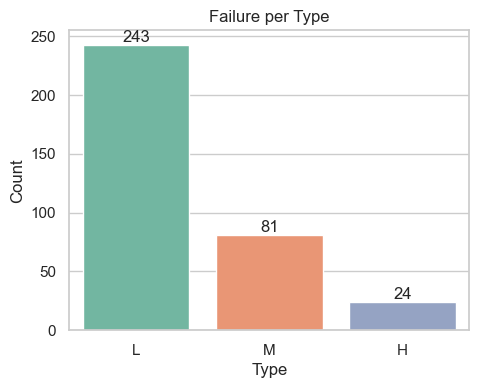

In [41]:
fig = plt.figure(figsize=(8,6), dpi= 100)
ax = sns.set_theme(style="whitegrid")
ax = fig.add_axes([0.1, 0.1, 0.5, 0.5])
ax = sns.countplot(data= df.query("target == 1"), x='type', palette="Set2",
                   order=['L', 'M', 'H'])

for c in ax.containers:
    ax.bar_label(c)
    
ax.set_title('Failure per Type')
ax.set_xlabel('Type')
ax.set_ylabel('Count')
plt.show()


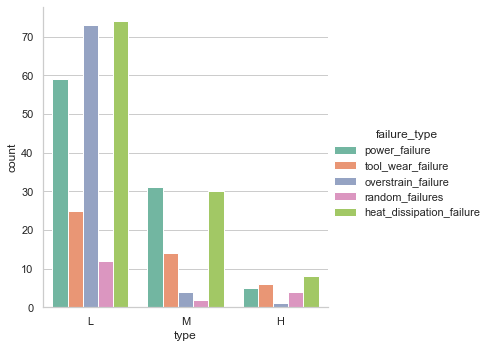

In [42]:
ax = sns.set_theme(style="whitegrid")
ax = sns.catplot(data= df.query("target == 1"), x='type', palette="Set2", hue='failure_type', kind='count',
                   order=['L', 'M', 'H'])
plt.show()

From the barchart above we can see that the machine with type 'L' or stands for 'Low Quality' tends to be Failured compared to machine with type 'H' or stands for 'High Quality'.  

In [67]:
df.groupby('type')['target'].count()

type
H    1003
L    6000
M    2997
Name: target, dtype: int64

The problem is the product with type L or 'Low' are consist about 60 % of all product,
as we can see product with type H or 'High' are only about 10 % of the product, hence we cannot
conclude that product with type H are much better than product with type L in term of Failures,
so we need to see the ratio of total failure on each types 

In [10]:
df_failured = df.query('failure_type != "no_failure"')

In [11]:
count_type_L = len(df[df['type'] == 'L'])
count_failure__L = len(df_failured[df_failured['type'] == 'L'])
print('Type L Failure Ratio: {:.2f} %'.format(count_failure__L / count_type_L * 100))

count_type_M = len(df[df['type'] == 'M'])
count_failure__M = len(df_failured[df_failured['type'] == 'M'])
print('Type M Failure Ratio: {:.2f} %'.format(count_failure__M / count_type_M * 100))

count_type_H = len(df[df['type'] == 'H'])
count_failure__H = len(df_failured[df_failured['type'] == 'H'])
print('Type H Failure Ratio: {:.2f} %'.format(count_failure__H / count_type_H * 100))

Type L Failure Ratio: 4.05 %
Type M Failure Ratio: 2.70 %
Type H Failure Ratio: 2.39 %


as we can see that the product from type L are tend to be failured if we compared it with another product, but
we can directly conclude that because as we know that the data are imbalanced and the quantity of the type L
product are much more higher than others. 
----------------------------------------------------------------------------------------------------------------

In this phase of the project we will implement "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

Steps:
1. The first thing we have to do is determine how imbalanced is our target on the target's column to determine the amount for each label
2. Once we determine how many instances are considered as failure (Failure = "1") , we should bring the no failure's case to the same amount as failure case (assuming we want a 50/50 ratio), this will be equivalent to 348 cases of failure and 348 cases of no failure.

In [8]:
failure = df[df['target'] == 1]
no_failure = df[df['target'] == 0]

no_failure_undersampled = resample(no_failure, 
                                    n_samples= 348,
                                    random_state= 42)
df_resample = pd.concat([no_failure_undersampled, failure])

In this section we will plot the correlation matrices to determine which features that have high correlation with the failure's case

Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific condition is a failure. However, it is important that we use the correct dataframe (undersampled data) in order for us to see which features have a high positive or negative correlation with regards to failure case.

Summary and Explanation:
1. Negative Correlations: rotational speed are negatively correlated. Notice how the lower these values are, the more likely the end result will be a failure case.
2. Positive Correlations: air temperature, process temperature, and torque, are positively correlated. Notice how the higher these values are, the more likely the end result will be a failure case.
3. BoxPlots: We will use boxplots to have a better understanding of the distribution of these features in failured and non failured case.

Note: We have to make sure we use the undersample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

Text(0.5, 1.0, 'Correlation of each features')

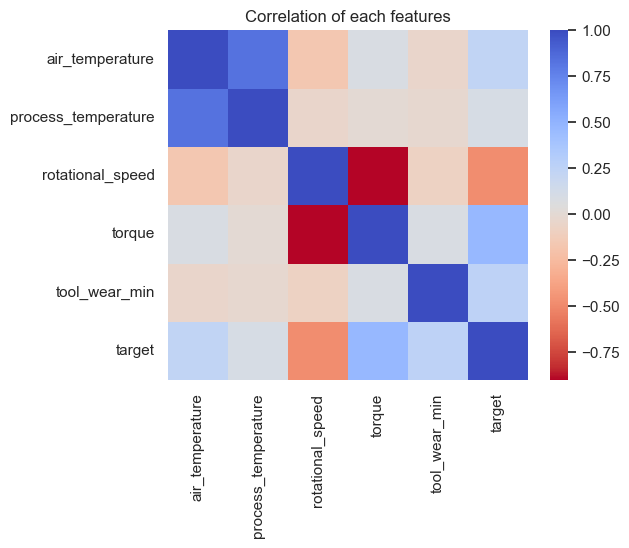

In [63]:
corr_df = df_resample.corr(method='spearman')
fig = plt.figure(figsize=(9,7), dpi= 100)
ax = fig.add_axes([0.1, 0.1, 0.5, 0.5])
ax = sns.heatmap(corr_df, cmap='coolwarm_r')
ax.set_title('Correlation of each features')

Our aim in this section is to replace the "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.


Interquartile Range Method:
1. Interquartile Range (IQR): We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.
2. Boxplots: Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme).

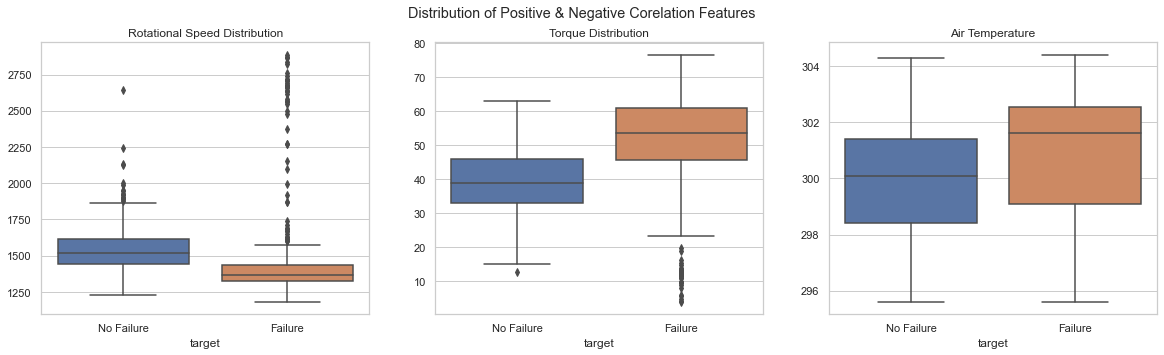

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

fig.suptitle('Distribution of Positive & Negative Corelation Features')

sns.boxplot(y ='rotational_speed', data=df_resample, x='target', ax=ax[0])
ax[0].set_title('Rotational Speed Distribution')
ax[0].set_ylabel('')
ax[0].set_xticklabels(['No Failure', 'Failure'], rotation= 0)

sns.boxplot(y ='torque', data=df_resample, x='target', ax=ax[1])
ax[1].set_title('Torque Distribution')
ax[1].set_xticklabels(['No Failure', 'Failure'], rotation= 0)
ax[1].set_ylabel('')

sns.boxplot(y ='air_temperature', data=df_resample, x='target', ax=ax[2])
ax[2].set_title('Air Temperature')
ax[2].set_xticklabels(['No Failure', 'Failure'], rotation= 0)
ax[2].set_ylabel('')

plt.show()

In [13]:
rs_failure = df_resample['rotational_speed'].loc[df_resample['target'] == 1].values
q25, q75 = np.percentile(rs_failure, 25), np.percentile(rs_failure, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
rs_iqr = q75 - q25
print('iqr: {}'.format(rs_iqr))

rs_cut_off = rs_iqr * 1.5
rs_lower, rs_upper = q25 - rs_cut_off, q75 + rs_cut_off
print('Cut Off: {}'.format(rs_cut_off))
print('Rotational speed Lower: {}'.format(rs_lower))
print('Rotational speed Upper: {}'.format(rs_upper))

rs_outliers = [x for x in rs_failure if x < rs_lower or x > rs_upper]
print('Feature Rotational Speed Outliers for Failure Cases: {}'.format(len(rs_outliers)))
print('% Rotational Speed Outliers for Failure Cases: {:.2f} %'.format(len(rs_outliers) / len(df_resample) * 100))
#print('Rotational speed outliers:{}'.format(rs_outliers))
print('-' * 238)

torque_failure = df_resample['torque'].loc[df_resample['target'] == 1].values
q25, q75 = np.percentile(torque_failure, 25), np.percentile(torque_failure, 75)
print('Quartile 25: {:.1f} | Quartile 75: {:.1f}'.format(q25, q75))
torque_iqr = q75 - q25
print('iqr: {:.3f}'.format(torque_iqr))

torque_cut_off = torque_iqr * 1.5
torque_lower, torque_upper = q25 - torque_cut_off, q75 + torque_cut_off
print('Cut Off: {:.3f}'.format(torque_cut_off))
print('Torque Lower: {:.3f}'.format(torque_lower))
print('Torque Upper: {:.3f}'.format(torque_upper))

torque_outliers = [x for x in torque_failure if x < torque_lower or x > torque_upper]
print('Torque Outliers for Failure Cases: {}'.format(len(torque_outliers)))
print('% Torque Outliers for Failure Cases: {:.2f} %'.format(len(torque_outliers) / len(df_resample) * 100))
#print('torque outliers:{}'.format(torque_outliers))
print('-' * 238)

Quartile 25: 1328.5 | Quartile 75: 1435.75
iqr: 107.25
Cut Off: 160.875
Rotational speed Lower: 1167.625
Rotational speed Upper: 1596.625
Feature Rotational Speed Outliers for Failure Cases: 50
% Rotational Speed Outliers for Failure Cases: 7.18 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: 45.7 | Quartile 75: 61.0
iqr: 15.400
Cut Off: 23.100
Torque Lower: 22.550
Torque Upper: 84.150
Torque Outliers for Failure Cases: 34
% Torque Outliers for Failure Cases: 4.89 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


We can see some outliers in the features especially in the failure case,  this outlier can decrease our model performance if we doest treat it, there some ways to deals with this situation such as replacing the outliers with the median of the features or also we can remove the data that contain the outliers if the amount of outliers within the data is relatively small. After identify the outliers that found in our high correlation features, since it have many outliers. we decided to replace it by the median to avoid information loss

In [67]:
rs_median = np.median(df_resample['rotational_speed'])
torque_median = np.median(df_resample['torque'])

df_resample['rotational_speed'] = df_resample['rotational_speed'].replace(rs_outliers, rs_median)
df_resample['torque'] = df_resample['torque'].replace(torque_outliers, torque_median)

# Feature Engineering

There were some columns that still with categorical type, thus it cannot be read to our machine learning model. so we need to convert the categorical column to the integer based column.

In [50]:
df['type'] = df['type'].astype('str')
df['failure_type'] = df['failure_type'].astype('str')

In [51]:
le = preprocessing.LabelEncoder()
df['failure_type'] = le.fit_transform(df['failure_type'])
df['type'] = df['type'].apply(lambda x: ['L', 'M', 'H'].index(x))

Splitting the data into two parts

I used the notation X (capital) to represent the column that we will use to make classification and y (lowercase) to represent the 
thing that we want to predict, in this case is whether or not the machine is failure on certain condition. in this case i also use
copy () method to ensure that the df_resample is not modified when we modify X or y, on the other words if we make a mistake when we
formatting the columns, I can just re-copy the df_resample rather than reload the original data 

in this case our dependent features or target features were the target columns and the independent features were air temperature, process temperature, rotational speed, torque and tool wear min

In [52]:
X = df.drop(['target', 'failure_type'], axis= 1).copy()
y = df['target'].copy()

since we know that the type's column were categorical type with no sequence. So we need to do one hot encoding (with dummies) to ensure that each type contribute equally. I also using drop first to the first dummies to avoid duplicated.
Then we ready to split the our data to train and test data. In this case we used 0.25 % (by default) of our data to be test data 

In [53]:
X_encoded = pd.get_dummies(X, columns=['type'], drop_first=True, prefix='type')
X_encoded.head()

,air_temperature,process_temperature,rotational_speed,torque,tool_wear_min,type_1,type_2
0,298.1,308.6,1551.0,42.8,0.0,1,0
1,298.2,308.7,1408.0,46.3,3.0,0,0
2,298.1,308.5,1498.0,49.4,5.0,0,0
3,298.2,308.6,1433.0,39.5,7.0,0,0
4,298.2,308.7,1408.0,40.0,9.0,0,0


In [27]:
y.value_counts(normalize= True)

0    0.9652
1    0.0348
Name: target, dtype: float64

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state= 42, stratify=y)

# Feature Scaling

Our data contains outliers in some features. so its better to choose the robust scaler that were not 
sensitive to outliers and ensuring that all of the independent feature were contribute equally with same weight

In [55]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Performing random oversampled

In [56]:
os = RandomOverSampler(0.6)
X_train_os, y_train_os = os.fit_resample(X_train, y_train)

print('before : {}'.format(Counter(y_train)))
print('after : {}'.format(Counter(y_train_os)))

before : Counter({0: 7239, 1: 261})
after : Counter({0: 7239, 1: 4343})


# Modelling

in this section we will try to fit the data to our model and identifying the training score of our preliminary model 

In [57]:
classifiers = {
    "Support Vector Classifier": SVC(),
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

for key, classifier in classifiers.items(): # Overfitting Case
    classifier.fit(X_train_os, y_train_os)
    training_score = cross_val_score(classifier, X_train_os, y_train_os, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  SVC Has a training score of 92.0 % accuracy score
Classifiers:  LogisticRegression Has a training score of 83.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 97.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 99.0 % accuracy score


as we can see in our preliminary model with the 5 cross validation, the Decision Tree classifier has the highest training score (99 %) compared to three other classification. 

# Hyperparameter Tuning

in this section we will search the best parameter of each classifier in order to improve each model's score

In [58]:
param_grid = [{'gamma':['scale', 0.1],
                'C': [0.5, 1],
                'kernel':['rbf']}]

svm_optimal_params = GridSearchCV(
                    SVC(probability=True),
                    param_grid,
                    cv= 5)

svm_optimal_params.fit(X_train_os, y_train_os)
y_pred_svm = svm_optimal_params.predict(X_test)
y_proba_svm = svm_optimal_params.predict_proba(X_test)

print('SVM Best Params : {}'.format(svm_optimal_params.best_params_))
print('SVM Best CV Score : {}'.format(svm_optimal_params.best_score_))
print('best score (Precision) : {:.3f}'.format(precision_score(y_test, y_pred_svm)))
print('best score (Recall) : {:.3f}'.format(recall_score(y_test, y_pred_svm)))

SVM Best Params : {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Best CV Score : 0.9233299268081604
best score (Precision) : 0.350
best score (Recall) : 0.862


In [59]:
l1_space = np.linspace(0, 1, 30)
#c_space = np.logspace(-5, 8, 15)

param_grid = [{'C': [0.01, 0.1, 0.5, 10],
              'penalty':['l1', 'l2'],
              'l1_ratio': l1_space}]

lr_optimal_params = GridSearchCV(
                    LogisticRegression(),
                    param_grid,
                    cv= 5)

lr_optimal_params.fit(X_train_os, y_train_os)
y_pred_lr = lr_optimal_params.predict(X_test)
y_proba_lr = lr_optimal_params.predict_proba(X_test)


print('Logistic Regression Best Params : {}'.format(lr_optimal_params.best_params_))
print('Logistic Regression best score: {}'.format(lr_optimal_params.best_score_))
print('best score (Precision) : {:.3f}'.format(precision_score(y_test, y_pred_lr)))
print('best score (Recall) : {:.3f}'.format(recall_score(y_test, y_pred_lr)))

Logistic Regression Best Params : {'C': 0.01, 'l1_ratio': 0.0, 'penalty': 'l2'}
Logistic Regression best score: 0.8280957822447734
best score (Precision) : 0.215
best score (Recall) : 0.759


In [60]:
param_grid = [{"n_neighbors": np.arange(25, 30),
               'algorithm': ['auto', 'ball_tree']}]

knn_optimal_params = GridSearchCV(
                    KNeighborsClassifier(),
                    param_grid,
                    cv= 5)

knn_optimal_params.fit(X_train_os, y_train_os)
y_pred_knn = knn_optimal_params.predict(X_test)
y_proba_knn = knn_optimal_params.predict_proba(X_test)

print('KNN Best Params : {}'.format(knn_optimal_params.best_params_))
print('KNN Best CV Score : {}'.format(knn_optimal_params.best_score_))
print('best score (Precision) : {:.3f}'.format(precision_score(y_test, y_pred_knn)))
print('best score (Recall) : {:.3f}'.format(recall_score(y_test, y_pred_knn)))

KNN Best Params : {'algorithm': 'auto', 'n_neighbors': 26}
KNN Best CV Score : 0.9084793033096963
best score (Precision) : 0.210
best score (Recall) : 0.759


In [61]:
param_grid = [{'criterion':['gini', 'entropy'],
                'max_depth': list(range(10,13,1)),
                'min_samples_leaf':list(range(2,5,1)),
                'min_samples_split':list(range(2,5,1))}]

dtree_optimal_params = GridSearchCV(
                    DecisionTreeClassifier(),
                    param_grid,
                    cv= 5)

dtree_optimal_params.fit(X_train_os, y_train_os)
y_pred_dtree = dtree_optimal_params.predict(X_test)
y_proba_dtree = dtree_optimal_params.predict_proba(X_test)


print('Decision Tree Best Params : {}'.format(dtree_optimal_params.best_params_))
print('Decision Tree Best CV Score : {}'.format(dtree_optimal_params.best_score_))
print('best score (Precision) : {:.3f}'.format(precision_score(y_test, y_pred_dtree)))
print('best score (Recall) : {:.3f}'.format(recall_score(y_test, y_pred_dtree)))

Decision Tree Best Params : {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 4}
Decision Tree Best CV Score : 0.9863576866339729
best score (Precision) : 0.561
best score (Recall) : 0.632


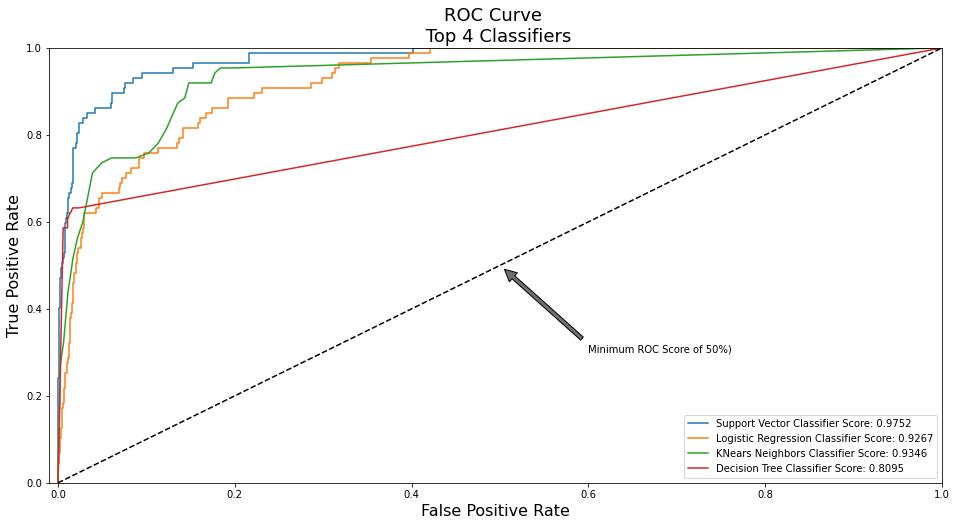

In [62]:
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, y_proba_svm[:,1])
log_fpr, log_tpr, log_threshold = roc_curve(y_test, y_proba_lr[:,1])
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_test, y_proba_knn[:,1])
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, y_proba_dtree[:,1])

def plot_roc_curve_multiple(svc_fpr, svc_tpr, log_fpr, log_tpr, knear_fpr, knear_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_test, y_proba_svm[:,1])))
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_test, y_proba_lr[:,1])))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_test, y_proba_knn[:,1])))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_test, y_proba_dtree[:,1])))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50%)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
plot_roc_curve_multiple(svc_fpr, svc_tpr, log_fpr, log_tpr, knear_fpr, knear_tpr, tree_fpr, tree_tpr)
plt.show()

In this case SVM classifier has the highest ROC-AUC Score compared to three other classifier after optimized

# Build the optimized model

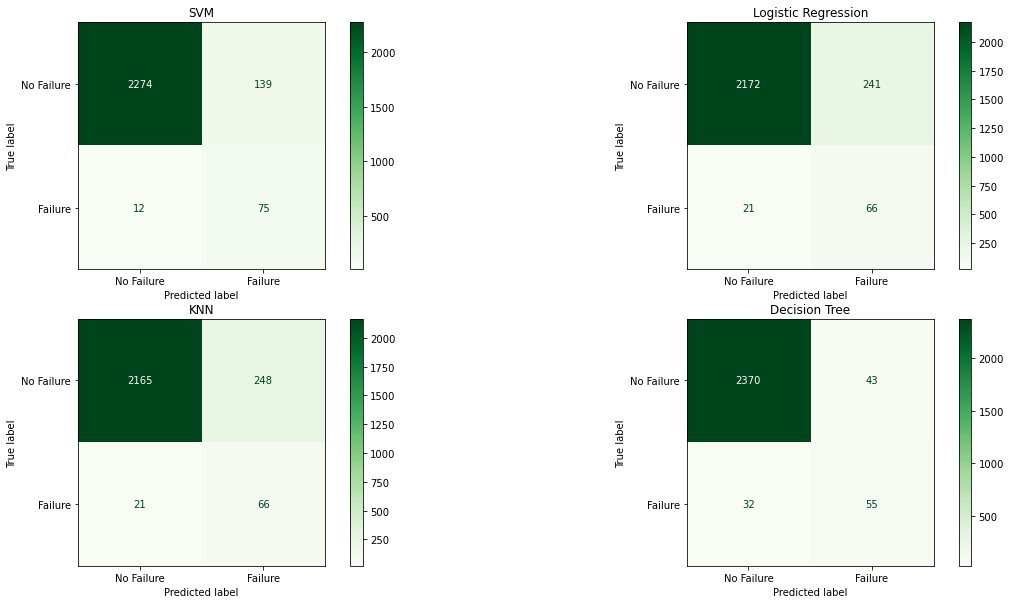

In [63]:
fig, ax = plt.subplots(2, 2,figsize=(20,10))

plot_confusion_matrix(svm_optimal_params, X_test, y_test, cmap=plt.cm.Greens,
                      ax=ax[0,0], display_labels = ['No Failure', 'Failure'])
ax[0,0].set_title('SVM')
ax[0,0].grid(False)

plot_confusion_matrix(lr_optimal_params, X_test, y_test, cmap=plt.cm.Greens,
                     ax=ax[0,1], display_labels = ['No Failure', 'Failure'])
plt.grid(None)
ax[0,1].set_title('Logistic Regression')
ax[0,1].grid(False)

plot_confusion_matrix(knn_optimal_params, X_test, y_test, cmap=plt.cm.Greens,
                      ax=ax[1,0], display_labels = ['No Failure', 'Failure'])

ax[1,0].set_title('KNN')
ax[1,0].grid(False)

plot_confusion_matrix(dtree_optimal_params, X_test, y_test, cmap=plt.cm.Greens,
                      ax=ax[1,1], display_labels = ['No Failure', 'Failure'])

ax[1,1].set_title('Decision Tree')
ax[1,1].grid(False)

1. From the confusion matrix of the optimized model of SVM classifier we can see that from the 85 case that were failure 75 (88,2 %) were correctly classified. And from the 2415 case that were no failure, 2263 (93.7 %) were correctly classified. it was quite good straight out of the box without much optimization.

2. From the confusion matrix of the optimized model of Logistic Regression classifier we can see that from the 85 case that were failure 62 (73 %) were correctly classified. And from the 2415 case that were no failure, 2364 (89.1 %) were correctly classified. it was quite bad in we compared to the result from SVM classifier.

3. From the confusion matrix of of the optimized model of KNN classifier we can see that from the 85 case that were failure 73 (85,8 %) were correctly classified. And from the 2415 case that were no failure, 2165 (89.6 %) were correctly classified. 

4. From the confusion matrix of of the optimized model of Decision Tree classifier we can see that from the 85 case that were failure 65 (76,4 %) were correctly classified. And from the 2415 case that were no failure, 2364 (97.9 %) were correctly classified. it has the highest score in case of correctly classify no failure's machine

# Conclusion

1. The most frequent failure's that occurs in the machine product sequentially are Heat Dissipation Failure, Power Failure
Overstrain Failure, Total Wear Failure and Random failure. in this case the heat dissipation failure tends to appear at the high temperature and the lower speed of rotational speed. However, the most unfrequent failure's i.e random failure occurs with evenly distributed on all features except the rotational speed features, it tends to fail while the rotational speed were low.

2. The correlation between type of product with the occurance of failure case can't be concluded, because there were imbalance sample between each type of product. In this case the H product only consist 10 % of the total sample, the M product consist 30 % of the total sample and the L product occurs with the highest quantity or 60% of the total sample. Yet the ratio of failure in each product were 4.05 % for type L, 2.70 % for type M, and 2.39 % for type H. In this case we can say that the type H product or stand's for 'High Quality' had the lowest ratio of failure compared to other types

3. The features that have a high correlation to predict the machine failure were air temperature, torque, and rotational. In this case the higher value of air temperature and torque tends to make the machine's failure. Whereas the lower value of the rotational speed tends to make the machine's failure

4. From the result of our final confusion matrix above, in this case we can say that the Support Vector Machine (SVM) classifiers is better to classified the failure's machine compared with three other classifier. Later on our model's is ready to be use to make a prediction about whether or not the machine will failure at certain condition. And we can do the maintenance to machine that we predicted to be failured  